In [1]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/Dominik/R-workspace/cecelia/inst')

# MacOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# config
import py.config_utils as cfg

In [146]:
base_dir = '/Volumes/Analysis_SSD/Communal/cecelia/projects/az8y8l/ANALYSIS/'
zero_dir = os.path.join(base_dir, '0/auDGLN/')
im_path = os.path.join(zero_dir, 'ccidAvgCorrected.zarr')
version_num = 1
task_dir = os.path.join(base_dir, str(version_num), 'auDGLN')

In [152]:
im_path = '/Users/Dominik/Downloads/ccidImage.ome.zarr'

In [153]:
import py.zarr_utils as zarr_utils

im, _ = zarr_utils.open_as_zarr(im_path, as_dask=True)
im = im[0]

<zarr.hierarchy.Group '/0' read-only>


In [154]:
import py.ome_xml_utils as ome_xml_utils
from py.dim_utils import DimUtils

# get OME-XML
omexml = ome_xml_utils.parse_meta(im_path)

# create dim utils for image
dim_utils = DimUtils(omexml, use_channel_axis = True)
dim_utils.calc_image_dimensions(im.shape)

/Users/Dominik/Library/r-miniconda/envs/r-cecelia-env/lib/python3.9/site-packages/ome_types/_mixins/_base_type.py:117: UserWarning: Casting invalid DichroicID 'Beamsplitter.2412-349' to 'Dichroic:9'
  super().__init__(**data)
/Users/Dominik/Library/r-miniconda/envs/r-cecelia-env/lib/python3.9/site-packages/ome_types/_mixins/_base_type.py:117: UserWarning: Casting invalid DichroicID 'Beamsplitter.1520-117' to 'Dichroic:10'
  super().__init__(**data)
/Users/Dominik/Library/r-miniconda/envs/r-cecelia-env/lib/python3.9/site-packages/ome_types/_mixins/_base_type.py:117: UserWarning: Casting invalid DichroicID 'SecondaryBeamsplitter.453001-4023-000' to 'Dichroic:11'
  super().__init__(**data)


[1, 8, 40, 4158, 2349]
[2349, 4158, 40, 8, 1]
['X', 'Y', 'Z', 'C', 'T']


In [155]:
x_idx = dim_utils.dim_idx('X')
y_idx = dim_utils.dim_idx('Y')
c_idx = dim_utils.dim_idx('C')
z_idx = dim_utils.dim_idx('Z')

x_val = dim_utils.dim_val('X')
y_val = dim_utils.dim_val('Y')

In [156]:
import py.zarr_utils as zarr_utils

In [157]:
slices = [slice(None) for _ in range(len(im.shape))]
slices[c_idx] = 7

im_flat = zarr_utils.fortify(im[tuple(slices)])

In [158]:
im_flat.shape

(1, 40, 4158, 2349)

In [164]:
import math

# get 2D heatmap from 3D image
# get slices
slices = [slice(None) for _ in range(len(im_flat.shape))]

tile_xy = 200
tile_offset = 20
tile_list = list()

# top left
for k, z in enumerate(range(int(tile_xy/tile_offset))):
    tile_list.append(np.zeros(im_flat.shape, dtype = im_flat.dtype))
    
    for i, x in enumerate(range(0 + (z * tile_offset) - int(tile_xy/2), x_val + (z * tile_offset), tile_xy)):
        for j, y in enumerate(range(0 + (z * tile_offset) - int(tile_xy/2), y_val + (z * tile_offset), tile_xy)):
            slices[dim_utils.dim_idx('X', ignore_channel = True)] = slice(x, x + tile_xy, 1)
            slices[dim_utils.dim_idx('Y', ignore_channel = True)] = slice(y, y + tile_xy, 1)
            
            tile_list[-1][tuple(slices)] = np.average(im_flat[tuple(slices)])

# bottom right
for k, z in enumerate(range(int(tile_xy/tile_offset))):
    tile_list.append(np.zeros(im_flat.shape, dtype = im_flat.dtype))
    print(k)
    
    for i, x in enumerate(range(x_val - (z * tile_offset), 0 - (z * tile_offset) - int(tile_xy/2), -tile_xy)):
        for j, y in enumerate(range(y_val - (z * tile_offset), 0 - (z * tile_offset) - int(tile_xy/2), -tile_xy)):
            slices[dim_utils.dim_idx('X', ignore_channel = True)] = slice(x - tile_xy, x, 1)
            slices[dim_utils.dim_idx('Y', ignore_channel = True)] = slice(y - tile_xy, y, 1)
            
            tile_list[-1][tuple(slices)] = np.average(im_flat[tuple(slices)])

/Users/Dominik/Library/r-miniconda/envs/r-cecelia-env/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/Dominik/Library/r-miniconda/envs/r-cecelia-env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1
2
3
4
5
6
7
8
9


In [165]:
# now puzzle together
im_heat = np.average(np.stack(tile_list), axis = 0)

viewer.add_image(im_heat)

<Image layer 'im_heat [1]' at 0x271a95250>

In [4]:
import napari

viewer = napari.viewer.Viewer()

In [163]:
viewer.add_image(im, channel_axis=1, visible=False)

[<Image layer 'Image' at 0x2214ec640>,
 <Image layer 'Image [1]' at 0x21edf2340>,
 <Image layer 'Image [2]' at 0x32aceeb20>,
 <Image layer 'Image [3]' at 0x22006c100>,
 <Image layer 'Image [4]' at 0x334a19340>,
 <Image layer 'Image [5]' at 0x3299d0250>,
 <Image layer 'Image [6]' at 0x329765670>,
 <Image layer 'Image [7]' at 0x3297b6070>]

In [105]:
from skimage.morphology import disk
from skimage.filters import rank

footprint = disk(200)

viewer.add_image(rank.mean_bilateral(np.squeeze(im_flat), footprint=footprint, s0=500, s1=500))

<Image layer 'Image [10]' at 0x274e7bac0>

In [ ]:
import py.correction_utils as correction_utils

In [39]:
x_idx = dim_utils.dim_idx('X')
y_idx = dim_utils.dim_idx('Y')
c_idx = dim_utils.dim_idx('C')
c_val = dim_utils.dim_val('C')

In [40]:
slices = [slice(None) for _ in range(len(im.shape))]
slices[x_idx] = slice(500, 1000, 1)
slices[y_idx] = slice(2000, 2500, 1)

In [41]:
list(range(0, 101, 10))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

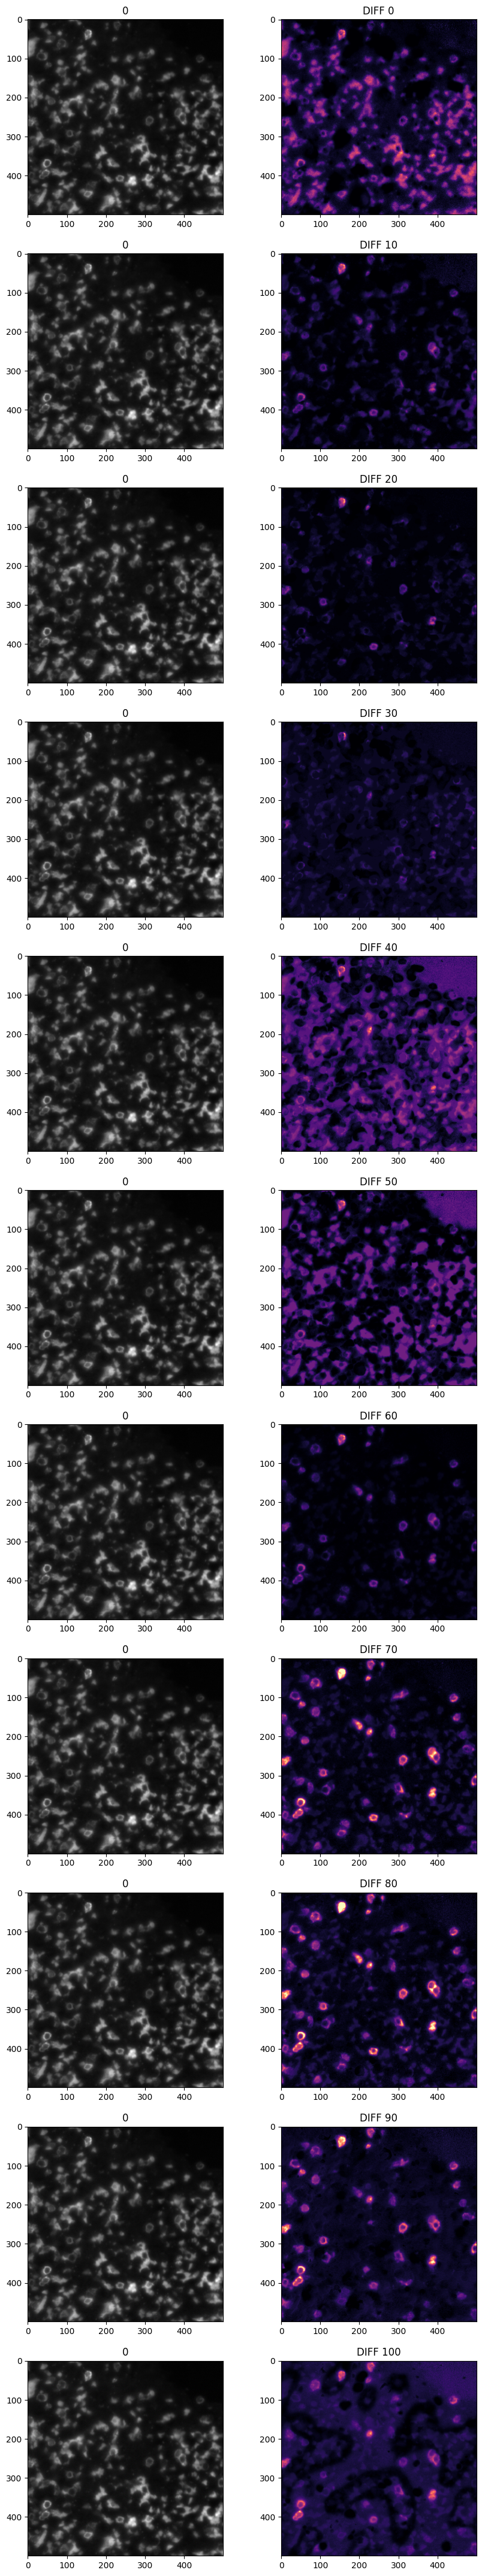

In [42]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,c_val * 5))
percentile = 75

im_slices = [slice(None) for _ in range(len(im.shape))]
im_slices[x_idx] = slice(500, 1000, 1)
im_slices[y_idx] = slice(2000, 2500, 1)

for i, x in enumerate([4]):
    for j, y in enumerate(range(0, 101, 10)):
        a = correction_utils.af_correct_image(
            im, {
            #im[tuple(slices)], {
                i: {
                    'divisionChannels': list(range(c_val)),
                    'summaryMode': 'percentile',
                    'correctionMode': 'divide',
                    'summaryPercentile': y,
                    'channelPercentile': 0,
                    'correctionPercentile': 0,
                    'medianFilter': 0,
                    'generateInverse': False,
                    'correctionMin': 0.1,
                    'correctionMax': 99.9
                } for i in range(c_val)
            }, dim_utils = dim_utils, gaussian_sigma = 0
        )
        
        slices[c_idx] = x
        im_slices[c_idx] = x
        
        plt.subplot(c_val,2,(j*2)+1)
        plt.imshow(np.squeeze(im[tuple(slices)]), cmap='gray')
        plt.title(i)
        
        plt.subplot(c_val,2,(j*2)+2)
        plt.imshow(np.squeeze(a[tuple(im_slices)]), cmap='magma')
        plt.title(f'DIFF {y}')

In [9]:
import napari

viewer = napari.viewer.Viewer()

In [12]:
viewer.add_image(im, channel_axis=1, visible=False)

[<Image layer 'Image' at 0x12710c160>,
 <Image layer 'Image [1]' at 0x128361160>,
 <Image layer 'Image [2]' at 0x2052317c0>,
 <Image layer 'Image [3]' at 0x20573e910>,
 <Image layer 'Image [4]' at 0x1971c0460>,
 <Image layer 'Image [5]' at 0x194301130>,
 <Image layer 'Image [6]' at 0x196ac7040>,
 <Image layer 'Image [7]' at 0x194d155e0>,
 <Image layer 'Image [8]' at 0x197199e50>,
 <Image layer 'Image [9]' at 0x1975d3370>,
 <Image layer 'Image [10]' at 0x208ded3a0>,
 <Image layer 'Image [11]' at 0x22423b4c0>,
 <Image layer 'Image [12]' at 0x223b78700>,
 <Image layer 'Image [13]' at 0x223bb4940>,
 <Image layer 'Image [14]' at 0x223b54b80>,
 <Image layer 'Image [15]' at 0x224138dc0>,
 <Image layer 'Image [16]' at 0x223e07040>,
 <Image layer 'Image [17]' at 0x223b03280>,
 <Image layer 'Image [18]' at 0x20d7394c0>,
 <Image layer 'Image [19]' at 0x20d770700>,
 <Image layer 'Image [20]' at 0x20d7159d0>,
 <Image layer 'Image [21]' at 0x2241d4f10>,
 <Image layer 'Image [22]' at 0x223d86490>,
 <

In [ ]:
import skimage.filters
import skimage.morphology

In [ ]:
avg_slices = [slice(None) for _ in range(len(im.shape))]
avg_slices[x_idx] = slice(500, 1000, 1)
avg_slices[y_idx] = slice(2000, 2500, 1)

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,c_val * 5))
percentile = 75

for i, x in enumerate(range(c_val)):  
    slices[c_idx] = x
    plt.subplot(c_val,2,(i*2)+1)
    plt.imshow(np.squeeze(im[tuple(slices)]), cmap='gray')
    plt.title(i)
    
    plt.subplot(c_val,2,(i*2)+2)
    plt.imshow(np.squeeze(
        (np.squeeze(im[tuple(slices)]) + 1) / (np.percentile(im[tuple(avg_slices)].compute(), percentile, axis = c_idx).astype(np.uint8) + 1)
    ), cmap='magma')
    plt.title(f'DIFF {i}')